# Applications of autoencoders

This study investigates the use of the variational autoencoder (VAE) to work with simple geometric objects such as ellipses. The main task is to explore the hidden representation of the VAE and extract some interesting properties.

Required imports:

In [ ]:
from PIL import Image, ImageDraw
import random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import math
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Dataset generation

First, to generate a dataset we create a function that returns an image of an ellipse of random area and rotated by a random angle.

In [ ]:
def gen_data(x, y):
    angle = random.uniform(0, 180)
    im = Image.new('1', (x,y), color = 1)
    draw = ImageDraw.Draw(im)
    x1 = random.uniform(2, x/2 - 2)
    y1 = random.uniform(2, y/2 - 2)
    draw.ellipse((x1, y1, x - x1, y - y1), fill="black", outline="black")
    im = im.rotate(angle, fillcolor = 'white')
    arr = np.array(im, dtype = int)
    return arr

Visualize sample images

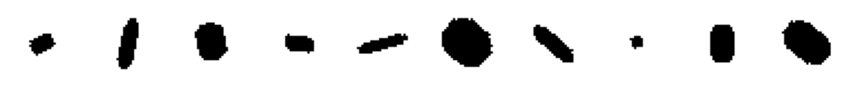

In [ ]:
fig = plt.figure(figsize=(15, 20))

for i in range(1,11):
  fig.add_subplot(1, 10, i)
  plt.imshow(gen_data(32,32), 'gray')
  plt.axis('off')

Generate the dataset

In [ ]:
x_train = [gen_data(32,32) for _ in range(25000)]

In [ ]:
x_test = [gen_data(32,32) for _ in range(5000)]

# VAE architecture

Create a sampling layer

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Build the encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(32, 32, 1))
x = layers.Conv2D(4, 3, activation="elu", strides=2, padding="same")(encoder_inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, 3, activation="elu", strides=2, padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, 2, activation="elu", strides=2, padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, 2, activation="elu", strides=2, padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, 2, activation="elu", strides=2, padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, 1, activation="elu", strides=2, padding="same")(x)
x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 4)      0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 16)     592         max_pooling2d[0][0]              
____________________________________________________________________________________________

Build the decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(1 * 1 * 64, activation="elu")(latent_inputs)
x = layers.Reshape((1, 1, 64))(x)
x = layers.Conv2DTranspose(64, 2, activation="elu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 2, activation="elu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 2, activation="elu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="elu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(4, 3, activation="elu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                192       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 2, 64)          16448     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 32)          8224      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 32)          4128      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 16)        4624

Define the VAE

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 10 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Train the VAE

For training, we need to reshape the dataset

In [ ]:
x_train = np.reshape(x_train, (len(x_train), 32, 32, 1))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 1))

Let's put the number of epochs at 200 and the size of the batch at 1000

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=200, batch_size=1000)

Epoch 1/200
25/25 [==============================] - 15s 524ms/step - loss: 700.1310 - reconstruction_loss: 681.8554 - kl_loss: 0.0221
Epoch 2/200
25/25 [==============================] - 13s 517ms/step - loss: 501.3690 - reconstruction_loss: 417.3340 - kl_loss: 1.9583
Epoch 3/200
25/25 [==============================] - 13s 516ms/step - loss: 334.7689 - reconstruction_loss: 297.4686 - kl_loss: 1.5696
Epoch 4/200
25/25 [==============================] - 13s 515ms/step - loss: 246.1328 - reconstruction_loss: 210.8472 - kl_loss: 2.4100
Epoch 5/200
25/25 [==============================] - 13s 518ms/step - loss: 212.3655 - reconstruction_loss: 185.0188 - kl_loss: 2.4328
Epoch 6/200
25/25 [==============================] - 13s 518ms/step - loss: 201.5661 - reconstruction_loss: 177.4250 - kl_loss: 2.3350
Epoch 7/200
25/25 [==============================] - 13s 517ms/step - loss: 198.3435 - reconstruction_loss: 173.8097 - kl_loss: 2.2651
Epoch 8/200
25/25 [==============================] - 13

## Plotting the loss function

Look at the loss function's graph

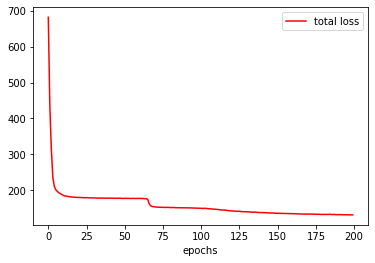

In [ ]:
plt.plot(vae.history.history['loss'], color='red', label='total loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

# Model testing

Firstly, create a function that draws input and output ellipses

In [ ]:
def plot_ellipse(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(n, len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

After, visualize the VAE performance

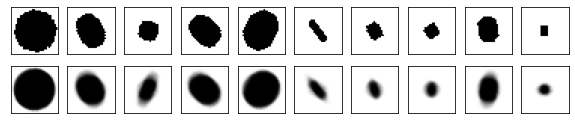

In [ ]:
n = 10

encoded_imgs = vae.encoder.predict(x_test[:n], batch_size=n)
decoded_imgs = vae.decoder.predict(encoded_imgs[0], batch_size=n)

plot_ellipse(x_test[:n], decoded_imgs)

## Hidden space

Transform each input image into the latent vector and plot it

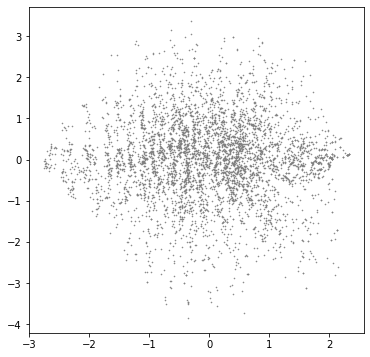

In [ ]:
h = np.array(vae.encoder.predict(x_test))

plt.figure(figsize=(6,6))
plt.scatter(h[0, :, 0], h[0, :, 1], marker='o', s=0.3, c='grey')
plt.show()

# The distribution of areas and angles

Consider the distribution of areas of ellipses and angles of rotation about a major axis, depending on the coordinate in the hidden space

First, define a function for calculating area and rotation angle of a ellipse

In [ ]:
def get_features(arr):
  arr1 = np.where((arr==0), 1 , 0)
  label_img = label(arr1)
  
  props = regionprops_table(label_img, properties=('orientation','area'))
                                               
  area = props['area'][0]
  angle = props['orientation'][0]*180/math.pi
  return area, angle

Sample ellipses from the hidden space and investigate the distribution of angles and areas

To sample ellipses from the hidden space we generate random points in the two-dimensional latent space

In [ ]:
points = -2 + 4*np.random.rand(5000, 2)

Reconstruct ellipses using the decoder

In [ ]:
ellipses = np.reshape(vae.decoder.predict(points),(-1,32,32))

Calculate our features for each ellipse

In [ ]:
features = []
for img in ellipses:
  img = (img > 0.5).astype(int)
  features.append(get_features(img))
features = np.array(features)

Now let's draw the distribution of the angle of rotation

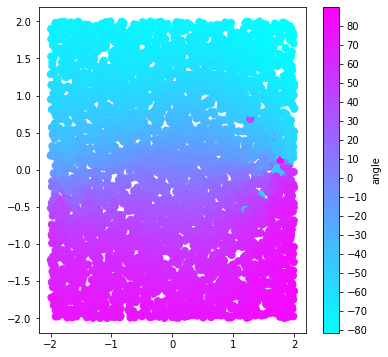

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], c=features[:,1], s=50, cmap='cool')
plt.colorbar(ticks=np.arange(-90,90,10), label='angle')
plt.show()

It can be noted, that the angle changes along the Y-axis

Similarly, let's draw the distribution of the area

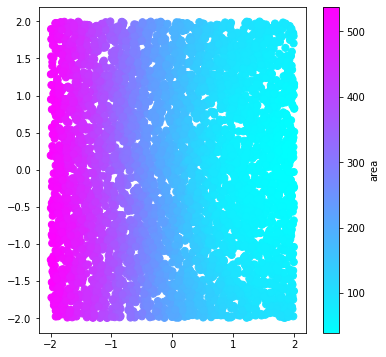

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], c=features[:,0], s=50, cmap='cool')
plt.colorbar(ticks=np.arange(0,1000,100), label='area')
plt.show()


As for the area, it changes along the X-axis.

## Animation

For clarity, let's take a look at the animation.

In [ ]:
def draw_ellipse(x, y):
  arr = np.array(vae.decoder.predict([[x,y]]))
  arr = arr.reshape(32,32)
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(arr, 'gray')
  return

In [ ]:
interact(draw_ellipse, x=(-2,2,0.01), y=(-2,2,0.01))

interactive(children=(FloatSlider(value=0.0, description='x', max=2.0, min=-2.0, step=0.01), FloatSlider(value…

<function __main__.draw_ellipse>

In total, we got an interesting conclusion, that one feature can be interpreted as an angle of rotation, the second one as an area.